In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))



TensorFlow version: 2.16.2
Num GPUs Available: 1


In [3]:
pip install matplotlib numpy pandas


  Using cached matplotlib-3.10.5-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached pandas-2.3.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached contourpy-1.3.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.1-cp310-cp310-macosx_10_9_universal2.whl.metadata (108 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached matplotlib-3.10.5-cp310-cp310-macosx_11_0_arm64.whl (8.1 MB)
Using cached pandas-2.3.1-cp310-cp310-macosx_11_0_arm64.whl (10.8 MB)
Using cached contourpy-1.3.2-cp310-cp310-macosx_11_0_arm64.whl (253 kB)
Using cached cycler-0

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [5]:
print(tf.__version__)


2.16.2


In [8]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 32
n_classes = 3

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2153 files belonging to 3 classes.


2025-08-20 16:40:39.231575: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-08-20 16:40:39.231609: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-20 16:40:39.231618: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-20 16:40:39.231651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-20 16:40:39.231659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy()) #3 is rgb channels 

(32, 256, 256, 3)
[1 1 2 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 2 0 0 2 0 0 1 2 1 0 0]


2025-08-20 16:41:46.385197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-08-20 16:41:50.227788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


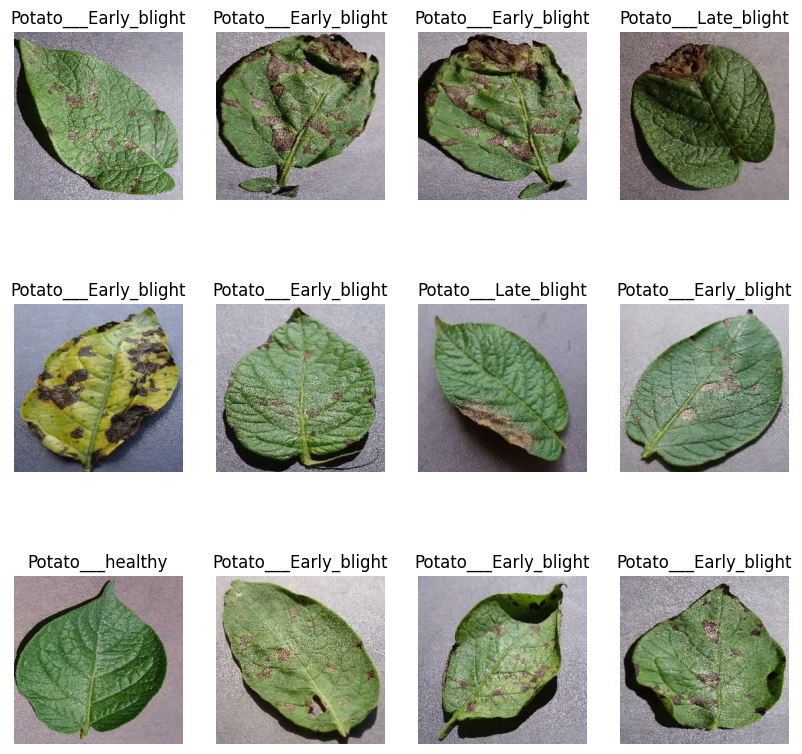

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
#traning split Dataset should be bifurcated into 3 subsets, namely:

#Training: Dataset to be used while training Validation: Dataset to be tested against while training Test: Dataset to be tested against after we trained a model

In [12]:
train_size = 0.8 #80% training dataset
len(dataset)*train_size


54.400000000000006

In [13]:
train_ds = dataset.take(54) #take first 54 samples they will be training dataset
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54) #54 onwards 
len(test_ds)

14

In [15]:
val_size=0.1 #validation dataset is 10 percent
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)


8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) #seed is for predictibility
    
    train_size = int(train_split * ds_size) #to get int numbers
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [24]:
len(test_ds)

8

In [ ]:
#Creating a Layer for Resizing and Normalization

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [23]:
#Data Augmentation

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [25]:
# Apply resize+rescale first
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y),
                        num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (resize_and_rescale(x), y),
                      num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (resize_and_rescale(x), y),
                       num_parallel_calls=tf.data.AUTOTUNE)


In [26]:
#Cache, Shuffle, and Prefetch the Dataset

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
# Apply augmentation only to train_ds
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [29]:
model = models.Sequential([
    # preprocessing is already done in dataset, so not adding here
    
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])


/opt/anaconda3/envs/tf-m2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,363 (56.61 MB)

 Trainable params: 14,839,363 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1
)

Epoch 1/15


2025-08-20 16:52:46.775531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.5972 - loss: 1.3105 - val_accuracy: 0.7760 - val_loss: 0.5595
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.7836 - loss: 0.6871 - val_accuracy: 0.8802 - val_loss: 0.4400
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.8252 - loss: 0.5116 - val_accuracy: 0.8594 - val_loss: 0.3638
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.8547 - loss: 0.4536 - val_accuracy: 0.8958 - val_loss: 0.2543
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.8750 - loss: 0.3894 - val_accuracy: 0.9271 - val_loss: 0.2016
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.8819 - loss: 0.3374 - val_accuracy: 0.8698 - val_loss: 0.3851
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.8663 - loss: 0.4291 - val_accuracy: 0.9167 - val_loss: 0.1417
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.8993 - loss: 0.3266 - val_accuracy: 0.9427 - val

In [33]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9531 - loss: 0.1215


In [34]:
scores #Scores is just a list containing loss and accuracy value

[0.12146475166082382, 0.953125]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [38]:
len(history.history['loss'])

15

In [39]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.3104652166366577,
 0.6870731711387634,
 0.5116438269615173,
 0.4535961151123047,
 0.38944074511528015]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


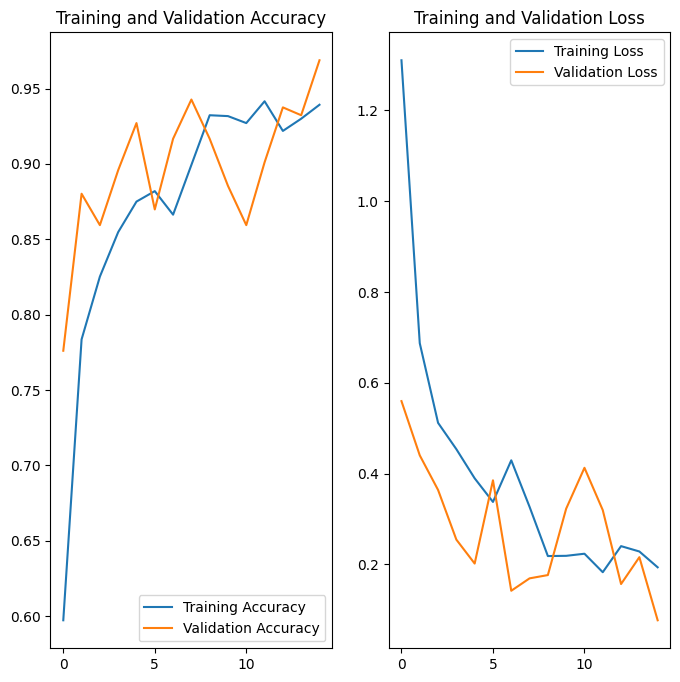

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # dynamically matches length

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
predicted label: Potato___Late_blight


2025-08-20 17:02:10.685346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


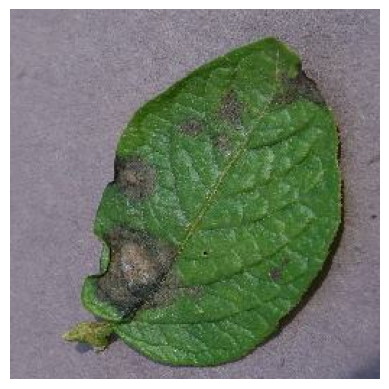

In [49]:
import numpy as np
import matplotlib.pyplot as plt

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy()  # still in [0,1]
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)  # don’t force uint8
    plt.axis("off")
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])


In [50]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2025-08-20 17:03:30.989167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


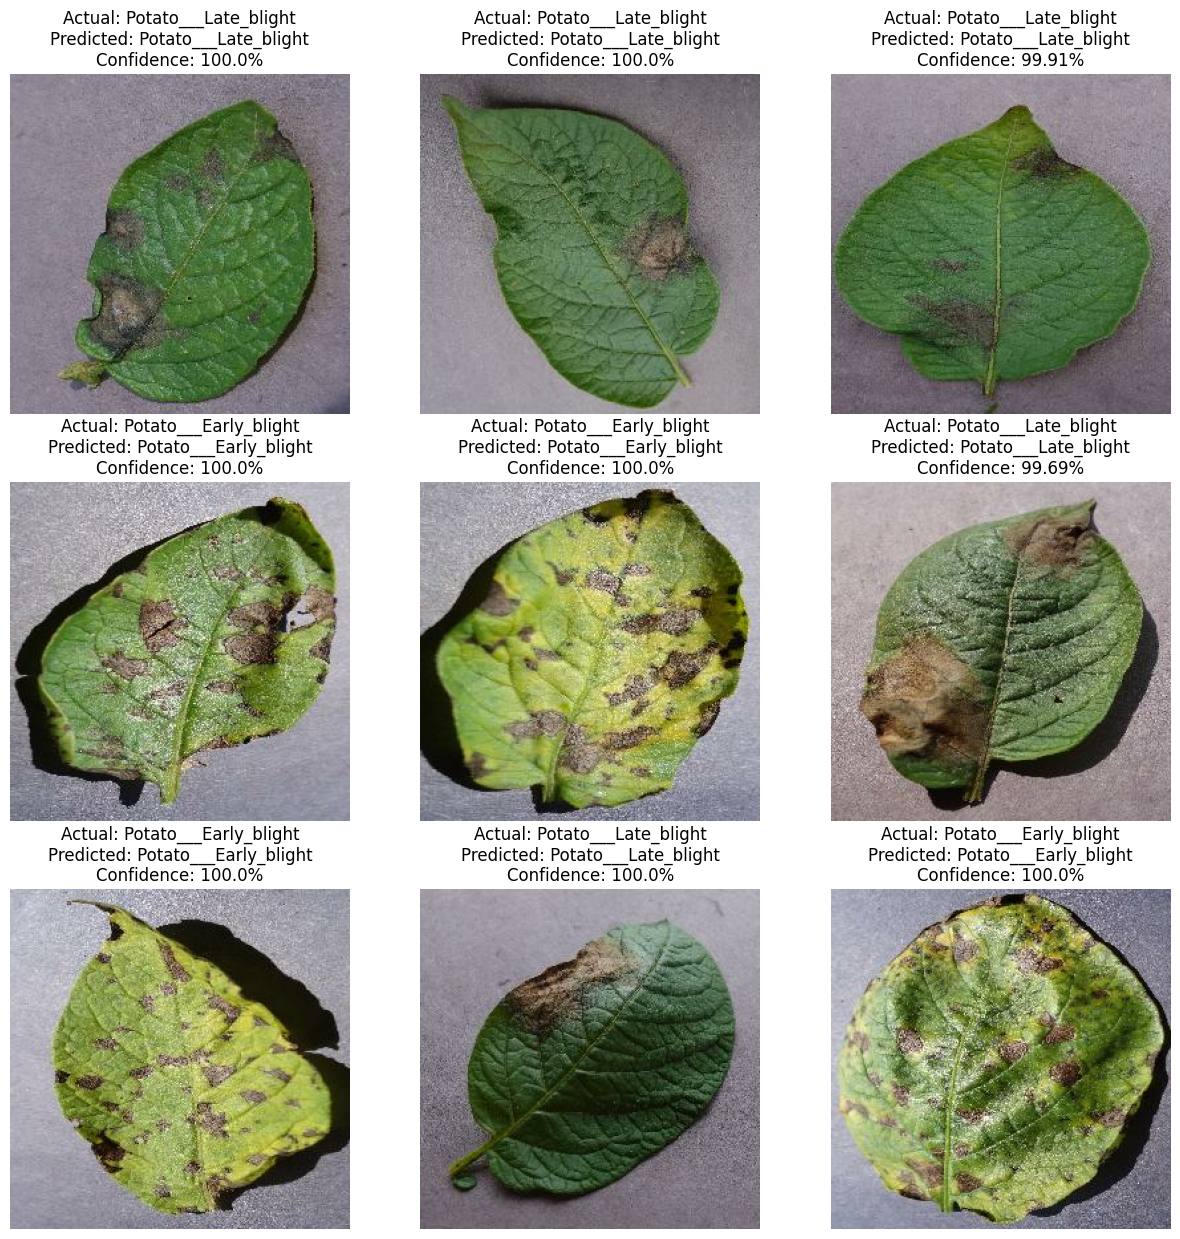

In [52]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())  # <-- no uint8 

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")


In [53]:
import os

# Path to your models folder
models_path = "/Users/anamta/Desktop/potato diseases/models"

# Ensure folder exists
os.makedirs(models_path, exist_ok=True)

# Auto-increment model version
existing = [int(i.split(".")[0]) for i in os.listdir(models_path) if i.split(".")[0].isdigit()] or [0]
model_version = max(existing) + 1

# Save with .keras extension
save_path = os.path.join(models_path, f"{model_version}.keras")
model.save(save_path)

print(f"✅ Model saved at: {save_path}")


✅ Model saved at: /Users/anamta/Desktop/potato diseases/models/2.keras


In [48]:
reqs = """tensorflow-macos
tensorflow-metal
fastapi
uvicorn
python-multipart
pillow
matplotlib
numpy"""
with open("../api/requirements.txt", "w") as f:
    f.write(reqs)
